In [101]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
import os
import joblib

In [102]:
def create_sequences(data, targets, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(targets[i + window_size])
    return np.array(X), np.array(y)

In [103]:
def add_temporal_features(df):
    df['HourSin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['HourCos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['DaySin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['DayCos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['MonthSin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['MonthCos'] = np.cos(2 * np.pi * df['Month'] / 12)
    return df

In [104]:
def add_lagged_features(df, target_column, lags):
    for lag in lags:
        df[f'{target_column}_lag_{lag}'] = df[target_column].shift(lag)
    return df.dropna()

In [105]:
def load_and_preprocess_data(files, sheets, route_names):
    df_list = []
    
    for file, route_name in zip(files, route_names):
        if os.path.exists(file):
            for sheet in sheets:
                try:
                    temp_df = pd.read_excel(file, sheet_name=sheet)
                    
                    if 'TRAFFIC STATUS' in temp_df.columns:
                        temp_df.drop(columns=['TRAFFIC STATUS'], inplace=True)
                    
                    temp_df['TIME(24 HOUR)'] = temp_df['TIME(24 HOUR)'].astype(str).str.zfill(5) + ':00'
                    temp_df['Datetime'] = pd.to_datetime(
                        temp_df['DATE'].astype(str) + ' ' + temp_df['TIME(24 HOUR)'],
                        dayfirst=True, errors='coerce'
                    )
                    
                    temp_df = temp_df.dropna(subset=['Datetime']).sort_values('Datetime')
                    temp_df['Hour'] = temp_df['Datetime'].dt.hour
                    temp_df['DayOfWeek'] = temp_df['Datetime'].dt.dayofweek
                    temp_df['Month'] = temp_df['Datetime'].dt.month
                    temp_df['Route'] = route_name  # Add Route Information
                    temp_df = add_temporal_features(temp_df)
                    
                    df_list.append(temp_df)
                except Exception as e:
                    print(f"Error loading {file} - {sheet}: {e}")
    
    return pd.concat(df_list, ignore_index=True) if df_list else None

In [107]:
files = ['./dataset/MA-A.xlsx', './dataset/NORTHBOUND.xlsx', './dataset/SOUTHBOUND.xlsx']
route_names = ['MA-A', 'NORTHBOUND', 'SOUTHBOUND']
sheets = ["2018", "2019", "2020", "2021", "2022", "2023"]

df = load_and_preprocess_data(files, sheets, route_names)

df.tail()

,DATE,TIME(24 HOUR),DAY OF THE WEEK,WEATHER,ROAD CONDITION,HOLIDAY,ACCIDENTS,AVERAGE SPEED,TRAFFIC VOLUME,Datetime,Hour,DayOfWeek,Month,Route,HourSin,HourCos,DaySin,DayCos,MonthSin,MonthCos
62203,12/12/2023,19:00:00,Tuesday,Clear,Dry,NO,0,9,3219,2023-12-12 19:00:00,19,1,12,SOUTHBOUND,-0.965926,0.258819,0.781831,0.62349,-2.449294e-16,1.0
62204,12/12/2023,20:00:00,Tuesday,Clear,Dry,NO,0,5,2758,2023-12-12 20:00:00,20,1,12,SOUTHBOUND,-0.866025,0.500000,0.781831,0.62349,-2.449294e-16,1.0
62205,12/12/2023,21:00:00,Tuesday,Clear,Dry,NO,0,18,2169,2023-12-12 21:00:00,21,1,12,SOUTHBOUND,-0.707107,0.707107,0.781831,0.62349,-2.449294e-16,1.0
62206,12/12/2023,22:00:00,Tuesday,Clear,Dry,NO,0,13,1706,2023-12-12 22:00:00,22,1,12,SOUTHBOUND,-0.500000,0.866025,0.781831,0.62349,-2.449294e-16,1.0
62207,12/12/2023,23:00:00,Tuesday,Clear,Dry,NO,0,39,989,2023-12-12 23:00:00,23,1,12,SOUTHBOUND,-0.258819,0.965926,0.781831,0.62349,-2.449294e-16,1.0


In [108]:
# One-hot encode categorical features
categorical_cols = ['DAY OF THE WEEK', 'WEATHER', 'ROAD CONDITION', 'HOLIDAY']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Create dummy variables for the 'Route' column (ensures route selection is preserved)
df = pd.get_dummies(df, columns=['Route'], drop_first=False)

target_column = 'TRAFFIC VOLUME'

# ✅ Add lagged features (hourly/daily traffic patterns)
lags = [1, 2, 3, 6, 12, 24]
df = add_lagged_features(df, target_column, lags)

# Define features (excluding target and timestamp-related columns)
features = df.drop([target_column, 'DATE', 'TIME(24 HOUR)', 'Datetime'], axis=1)
target = df[target_column]

# Scale features and target variable
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(features)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1)).flatten()

# Create sequences for LSTM
window_size = 24
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

# Split into training and test sets (80% train, 20% test)
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

df.head()

,DATE,TIME(24 HOUR),ACCIDENTS,AVERAGE SPEED,TRAFFIC VOLUME,Datetime,Hour,DayOfWeek,Month,HourSin,...,HOLIDAY_YES,Route_MA-A,Route_NORTHBOUND,Route_SOUTHBOUND,TRAFFIC VOLUME_lag_1,TRAFFIC VOLUME_lag_2,TRAFFIC VOLUME_lag_3,TRAFFIC VOLUME_lag_6,TRAFFIC VOLUME_lag_12,TRAFFIC VOLUME_lag_24
24,02/01/2018,00:00:00,0,31,223,2018-01-02 00:00:00,0,1,1,0.000000,...,False,True,False,False,295.0,354.0,365.0,1590.0,974.0,224.0
25,02/01/2018,01:00:00,0,28,210,2018-01-02 01:00:00,1,1,1,0.258819,...,False,True,False,False,223.0,295.0,354.0,364.0,978.0,171.0
26,02/01/2018,02:00:00,0,29,233,2018-01-02 02:00:00,2,1,1,0.500000,...,False,True,False,False,210.0,223.0,295.0,527.0,1398.0,119.0
27,02/01/2018,03:00:00,0,34,230,2018-01-02 03:00:00,3,1,1,0.707107,...,False,True,False,False,233.0,210.0,223.0,365.0,1083.0,173.0
28,02/01/2018,04:00:00,0,28,255,2018-01-02 04:00:00,4,1,1,0.866025,...,False,True,False,False,230.0,233.0,210.0,354.0,1576.0,168.0


In [109]:
print("Training Features:", list(df.columns))

Training Features: ['DATE', 'TIME(24 HOUR)', 'ACCIDENTS', 'AVERAGE SPEED', 'TRAFFIC VOLUME', 'Datetime', 'Hour', 'DayOfWeek', 'Month', 'HourSin', 'HourCos', 'DaySin', 'DayCos', 'MonthSin', 'MonthCos', 'DAY OF THE WEEK_Monday', 'DAY OF THE WEEK_Saturday', 'DAY OF THE WEEK_Sunday', 'DAY OF THE WEEK_Thursday', 'DAY OF THE WEEK_Tuesday', 'DAY OF THE WEEK_Wednesday', 'WEATHER_Overcast', 'WEATHER_Passing Clouds', 'WEATHER_Rainy', 'WEATHER_Sunny', 'WEATHER_Thunderstorm', 'ROAD CONDITION_Wet', 'HOLIDAY_YES', 'Route_MA-A', 'Route_NORTHBOUND', 'Route_SOUTHBOUND', 'TRAFFIC VOLUME_lag_1', 'TRAFFIC VOLUME_lag_2', 'TRAFFIC VOLUME_lag_3', 'TRAFFIC VOLUME_lag_6', 'TRAFFIC VOLUME_lag_12', 'TRAFFIC VOLUME_lag_24']


In [131]:
model = Sequential([
    Input(shape=(window_size, X_train.shape[2])),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    Dense(32, activation='relu', kernel_regularizer=L2(0.01)),
    Dropout(0.3),
    Dense(1, activation='linear')
])

optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - loss: 0.1723 - mae: 0.0843 - val_loss: 0.0034 - val_mae: 0.0384
Epoch 2/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - loss: 0.0073 - mae: 0.0551 - val_loss: 0.0031 - val_mae: 0.0376
Epoch 3/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - loss: 0.0059 - mae: 0.0493 - val_loss: 0.0028 - val_mae: 0.0370
Epoch 4/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - loss: 0.0053 - mae: 0.0467 - val_loss: 0.0025 - val_mae: 0.0341
Epoch 5/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - loss: 0.0049 - mae: 0.0448 - val_loss: 0.0035 - val_mae: 0.0422
Epoch 6/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - loss: 0.0045 - mae: 0.0430 - val_loss: 0.0023 - val_mae: 0.0334
Epoch 7/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - loss: 0.0042 - mae: 0.0413 - val_loss: 0.0024 - val_mae: 0.0347
Epoch 8/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - loss: 0.0043 - mae: 0.0412 - val_loss: 0.0027 - val_mae: 0.0344
Epoch 9/100
622/622 ━━━━━━━━━━━━

In [132]:
y_pred_scaled = model.predict(X_test).flatten()
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

mae = mean_absolute_error(y_actual, y_pred)
mse = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_actual, y_pred)

print("\nPerformance on training:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

389/389 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step

Performance on training:
MAE: 268.1286
MSE: 117463.3215
RMSE: 342.7292
R2 Score: 0.9368


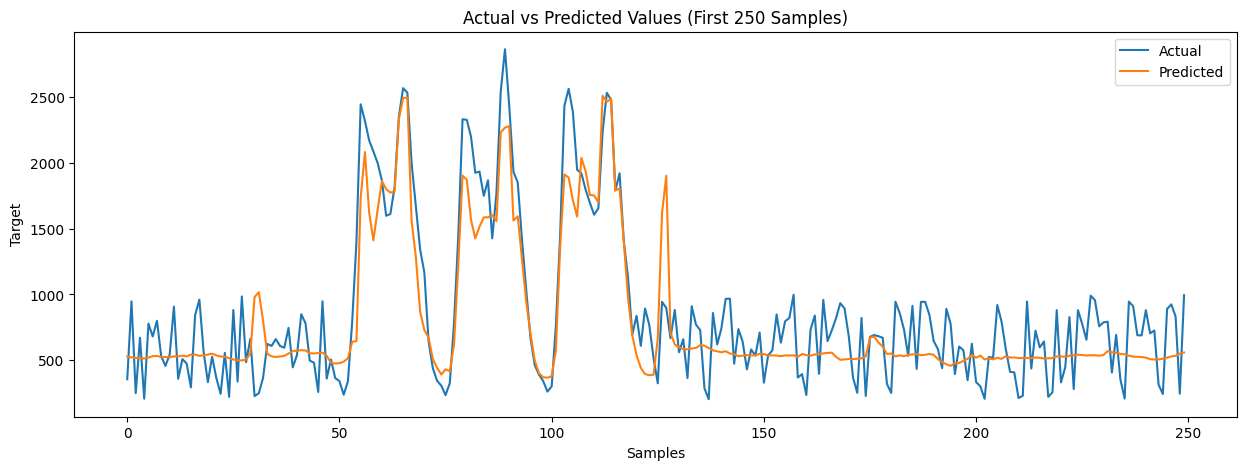

In [133]:
plt.figure(figsize=(15, 5))
plt.plot(y_actual[:250], label="Actual")
plt.plot(y_pred[:250], label="Predicted")
plt.title("Actual vs Predicted Values (First 250 Samples)")
plt.xlabel("Samples")
plt.ylabel("Target")
plt.legend()
plt.show()

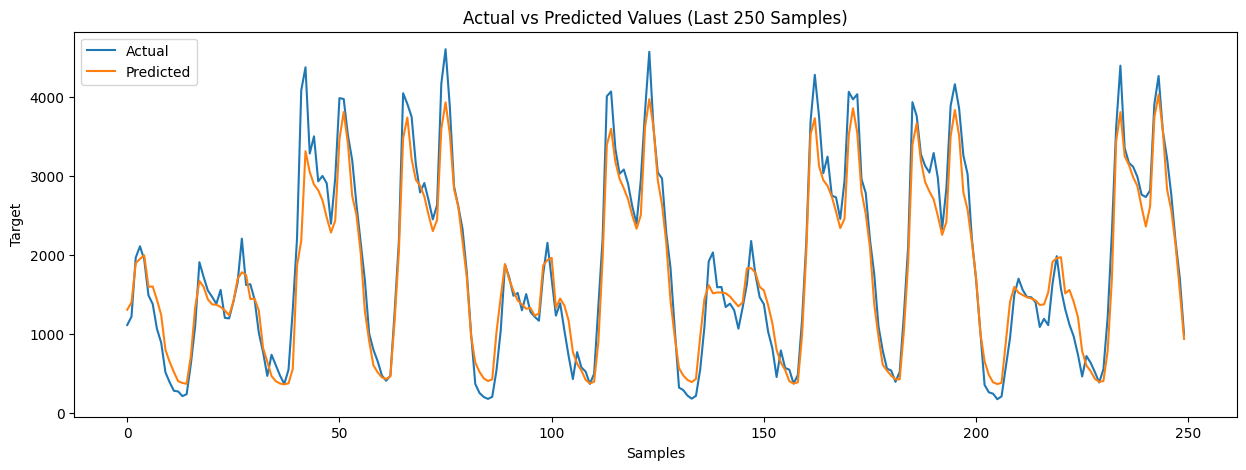

In [134]:
plt.figure(figsize=(15, 5))
plt.plot(y_actual[-250:], label="Actual")
plt.plot(y_pred[-250:], label="Predicted")
plt.title("Actual vs Predicted Values (Last 250 Samples)")
plt.xlabel("Samples")
plt.ylabel("Target")
plt.legend()
plt.show()

In [135]:
def filter_data(df, start_date, end_date, selected_route):
    df_filtered = df[
        (df['Datetime'] >= pd.to_datetime(start_date)) & 
        (df['Datetime'] <= pd.to_datetime(end_date))
    ]
    
    # If the selected route's dummy column exists, filter by it.
    dummy_col = f'Route_{selected_route}'
    if dummy_col in df_filtered.columns:
        df_filtered = df_filtered[df_filtered[dummy_col] == 1]
    else:
        # Otherwise, the selected route is the dropped baseline category.
        # In that case, filter rows where all other Route dummies are 0.
        route_dummies = [col for col in df_filtered.columns if col.startswith('Route_')]
        df_filtered = df_filtered[(df_filtered[route_dummies].sum(axis=1) == 0)]
    return df_filtered

In [140]:
def predict_traffic(model, start_date, end_date, selected_route, scaler_X, scaler_y, df):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Find the maximum available date in the dataset
    max_existing_date = df["Datetime"].max()

    # Case 1: If predicting future dates (beyond dataset range)
    if start_date > max_existing_date:
        print(f"📅 Predicting future dates from {start_date.date()} to {end_date.date()} using learned patterns.")

        # Generate future timestamps at hourly intervals
        future_dates = pd.date_range(start=start_date, end=end_date, freq="H")

        # Ensure enough time steps are created
        if len(future_dates) < window_size:
            print("⚠️ Not enough data points for prediction. Try a longer date range.")
            return pd.DataFrame(columns=["Date", "Time", "Day of the Week", "Predicted Traffic Volume"])

        # ✅ Create an empty DataFrame for future predictions
        df_future = pd.DataFrame({"Datetime": future_dates})

        # ✅ Explicitly create Date, Time, and Day of the Week before transformations
        df_future["Date"] = df_future["Datetime"].dt.date
        df_future["Time"] = df_future["Datetime"].dt.strftime("%H:%M:%S")  # Format as HH:MM:SS
        df_future["Day of the Week"] = df_future["Datetime"].dt.day_name()

        # ✅ Ensure 'Hour' and other features are created before adding temporal features
        df_future["Hour"] = df_future["Datetime"].dt.hour
        df_future["DayOfWeek"] = df_future["Datetime"].dt.dayofweek
        df_future["Month"] = df_future["Datetime"].dt.month

        # Add temporal features
        df_future = add_temporal_features(df_future)

        # ✅ Preserve Date, Time, and Day of the Week before modifying df_future
        df_output = df_future[["Date", "Time", "Day of the Week"]].copy()

        # ✅ Fill lag features using the most recent known values
        for lag in [1, 2, 3, 6, 12, 24]:
            lag_col = f'TRAFFIC VOLUME_lag_{lag}'
            if lag_col in df.columns:
                # Get the last 'lag' values for the selected route
                recent_vals = df[df[f'Route_{selected_route}'] == 1][target_column].dropna().tail(lag).tolist()

                # If not enough values are available, pad with mean
                if len(recent_vals) < lag:
                    recent_vals = [df[target_column].mean()] * lag

                # Assign last known traffic volume as lag feature
                df_future[lag_col] = recent_vals[-1]

        # Add missing categorical columns (Set them to 0)
        all_features = set(df.columns) - {"Datetime", target_column, "DATE", "TIME(24 HOUR)"}
        df_future = df_future.reindex(columns=all_features, fill_value=0)

        # ✅ Activate only the selected route
        route_column = f"Route_{selected_route}"
        route_columns = [col for col in df.columns if col.startswith("Route_")]

        # Ensure all route columns are set to 0 first
        for col in route_columns:
            df_future[col] = 0

        # Set the selected route column to 1 (if it exists in df_future)
        if route_column in df_future.columns:
            df_future[route_column] = 1
        else:
            print(f"⚠️ Warning: Route '{selected_route}' is not found in training data. Predictions may be incorrect.")

        # Drop unnecessary columns before scaling
        features = df_future.drop(columns=["Datetime"], errors="ignore")

    # Case 2: If predicting within the historical dataset
    else:
        df_filtered = filter_data(df, start_date, end_date, selected_route)

        if df_filtered.empty:
            print(f"⚠️ No data found for {selected_route} from {start_date.date()} to {end_date.date()}.")
            return pd.DataFrame(columns=["Date", "Time", "Day of the Week", "Predicted Traffic Volume"])

        # ✅ Extract Date, Time, and Day of the Week before modifying df_filtered
        df_output = pd.DataFrame()
        df_output["Date"] = df_filtered["Datetime"].dt.date
        df_output["Time"] = df_filtered["Datetime"].dt.strftime("%H:%M:%S")  # Format as HH:MM:SS
        df_output["Day of the Week"] = df_filtered["Datetime"].dt.day_name()

        # Drop columns not needed for prediction
        features = df_filtered.drop([target_column, 'DATE', 'TIME(24 HOUR)', 'Datetime'], axis=1)

    # Ensure columns match training order
    features = features[scaler_X.feature_names_in_]  # Matches training features

    # Scale the input features
    X_scaled = scaler_X.transform(features)

    # Create sequences for LSTM
    X_seq, _ = create_sequences(X_scaled, np.zeros(len(X_scaled)), window_size)

    # Ensure enough data points for sequence-based prediction
    if len(X_seq) == 0:
        print("❌ Not enough data for sequence-based prediction. Try selecting an earlier start date.")
        return pd.DataFrame(columns=["Date", "Time", "Day of the Week", "Predicted Traffic Volume"])

    # Run predictions through the trained LSTM model
    predictions_scaled = model.predict(X_seq).flatten()
    predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()

    # ✅ Ensure timestamps match predictions correctly
    df_output = df_output.iloc[: len(predictions)].reset_index(drop=True)  # Fix trimming issue
    df_output["Predicted Traffic Volume"] = predictions[: len(df_output)]  # Ensure correct length

    # ✅ Return only required columns
    return df_output

In [149]:
start_date = "2025-07-01"
end_date = "2025-07-04"
selected_route = "MA-A"

predicted_df = predict_traffic(model, start_date, end_date, selected_route, scaler_X, scaler_y, df)

if predicted_df.empty:
    print("❌ No predictions available.")
else:
    display(predicted_df)

📅 Predicting future dates from 2025-07-01 to 2025-07-04 using learned patterns.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/tmp/ipykernel_5136/2396719861.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=start_date, end=end_date, freq="H")


,Date,Time,Day of the Week,Predicted Traffic Volume
0,2025-07-01,00:00:00,Tuesday,314.888000
1,2025-07-01,01:00:00,Tuesday,308.705139
2,2025-07-01,02:00:00,Tuesday,318.705078
3,2025-07-01,03:00:00,Tuesday,340.820465
4,2025-07-01,04:00:00,Tuesday,386.959839
5,2025-07-01,05:00:00,Tuesday,465.073151
6,2025-07-01,06:00:00,Tuesday,1242.438599
7,2025-07-01,07:00:00,Tuesday,1326.584595
8,2025-07-01,08:00:00,Tuesday,1300.808960
9,2025-07-01,09:00:00,Tuesday,1017.823303


In [147]:
# Save the model
model.save("traffic_model.h5")

In [148]:
# Save the scalers
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")

['scaler_y.pkl']

In [144]:
df.to_parquet("preprocessed_data.parquet")